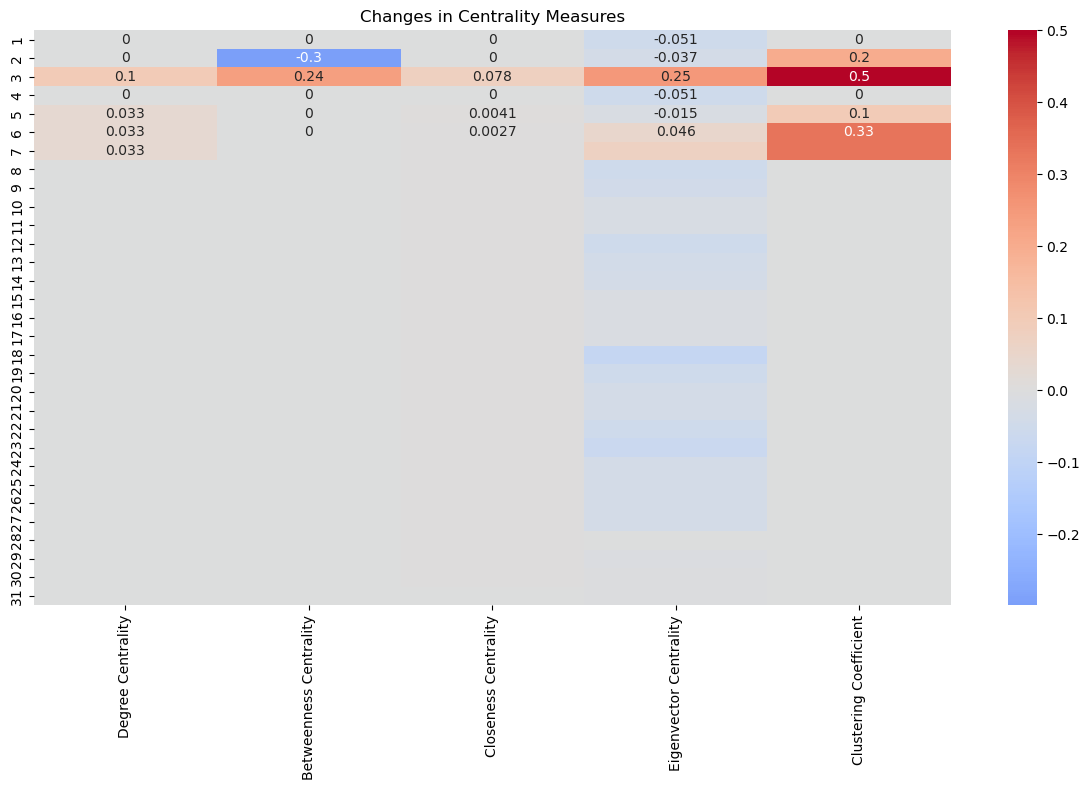

C:\Users\Service Casket\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
2024-09-10 09:53:41,014 - INFO - Visualization saved as Network_Snapshot_1.html
2024-09-10 09:53:41,090 - INFO - Visualization saved as Network_Snapshot_2.html


Detected Anomalies in Centrality Changes:
   Degree Centrality  Betweenness Centrality  Closeness Centrality  \
2           0.000000               -0.298851              0.000000   
3           0.100000                0.236782              0.078458   
5           0.033333                0.000000              0.004104   

   Eigenvector Centrality  Clustering Coefficient  anomaly  
2               -0.036736                     0.2       -1  
3                0.252463                     0.5       -1  
5               -0.015189                     0.1       -1  

Anomalies Explained:
Node 2:
  - Betweenness Centrality decreased significantly (z-score: -4.27)
Node 3:
  - Degree Centrality increased significantly (z-score: 4.67)
  - Betweenness Centrality increased significantly (z-score: 3.43)
  - Closeness Centrality increased significantly (z-score: 5.38)
  - Eigenvector Centrality increased significantly (z-score: 4.61)
  - Clustering Coefficient increased significantly (z-score: 3.68)

UnicodeEncodeError: 'charmap' codec can't encode characters in position 263607-263621: character maps to <undefined>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.ensemble import IsolationForest
import seaborn as sns
from pyvis.network import Network
import logging

# Configuration
CONFIG = {
    'clean_nodes': 'ICS_OT Nodes.csv',
    'clean_edges': 'ICS_OT Edges.csv',
    'infected_nodes': 'ICS_OT NodesInfected.csv',
    'infected_edges': 'ICS_OT EdgesInfected.csv',
    'anomaly_threshold': 0.1,
    'visualization_height': '600px',
    'visualization_width': '100%'
}

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_graph(nodes_file, edges_file):
    try:
        nodes_df = pd.read_csv(nodes_file)
        edges_df = pd.read_csv(edges_file)
        G = nx.Graph()
        
        for index, row in nodes_df.iterrows():
            G.add_node(row['Id'], label=row['Label'], shape=row.get('Shape', 'ellipse'))
        
        for index, row in edges_df.iterrows():
            G.add_edge(row['Source'], row['Target'], weight=row.get('Weight', 1))
        
        return G, nodes_df, edges_df
    except Exception as e:
        logging.error(f"Error loading graph: {str(e)}")
        return None, None, None

def calculate_centrality(G):
    centrality_measures = {
        'Degree Centrality': nx.degree_centrality(G),
        'Betweenness Centrality': nx.betweenness_centrality(G),
        'Closeness Centrality': nx.closeness_centrality(G),
        'Eigenvector Centrality': nx.eigenvector_centrality(G),
        'Clustering Coefficient': nx.clustering(G)
    }
    return pd.DataFrame(centrality_measures).sort_index()

def detect_anomalies(df, contamination=0.1):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    feature_names = df.columns.tolist()
    df['anomaly'] = iso_forest.fit_predict(df[feature_names])
    return df

def explain_anomalies(df, threshold=1.5):
    anomalies = df[df['anomaly'] == -1]
    explanations = {}
    
    for idx, row in anomalies.iterrows():
        explanations[idx] = []
        for col in df.columns[:-1]:  # Exclude the 'anomaly' column
            z_score = (row[col] - df[col].mean()) / df[col].std()
            if abs(z_score) > threshold:
                change = "increased" if z_score > 0 else "decreased"
                explanations[idx].append(f"{col} {change} significantly (z-score: {z_score:.2f})")
    
    return explanations

def visualize_network(G, title, height=CONFIG['visualization_height'], width=CONFIG['visualization_width']):
    net = Network(notebook=True, height=height, width=width, cdn_resources='in_line')
    net.from_nx(G)

    # Generate the HTML content manually instead of using net.show()
    html_content = net.generate_html(notebook=True)

    # Write the HTML content to a file with UTF-8 encoding
    try:
        with open(f'{title}.html', 'w', encoding='utf-8') as file:
            file.write(html_content)
        logging.info(f"Visualization saved as {title}.html")
    except Exception as e:
        logging.error(f"Error generating network visualization: {str(e)}")



def visualize_centrality_changes(G, centrality_changes, measure='Degree Centrality', title='Centrality Changes'):
    net = Network(notebook=True, height='600px', width='100%', cdn_resources='in_line')
    net.from_nx(G)
    
    # Normalize centrality changes for node sizes
    changes = centrality_changes[measure]
    min_change, max_change = changes.min(), changes.max()
    normalized_changes = (changes - min_change) / (max_change - min_change)
    
    for node in G.nodes():
        change = normalized_changes.get(node, 0)
        size = 10 + change * 40  # Node size between 10 and 50
        color = 'red' if change > 0 else 'blue'  # Red for increase, blue for decrease
        net.get_node(node)['size'] = size
        net.get_node(node)['color'] = color
        net.get_node(node)['title'] = f"Node {node}: Change = {changes.get(node, 0):.4f}"
    
    net.show(f'{title.replace(" ", "_")}.html')

def visualize_centrality_changes_heatmap(centrality_changes):
    plt.figure(figsize=(12, 8))
    sns.heatmap(centrality_changes, annot=True, cmap='coolwarm', center=0)
    plt.title('Changes in Centrality Measures')
    plt.tight_layout()
    plt.savefig('centrality_changes.png')
    plt.show()  # This will display the plot
    plt.close()

def compare_graphs(G1, G2):
    added_nodes = set(G2.nodes()) - set(G1.nodes())
    removed_nodes = set(G1.nodes()) - set(G2.nodes())
    added_edges = set(G2.edges()) - set(G1.edges())
    removed_edges = set(G1.edges()) - set(G2.edges())
    
    return {
        'added_nodes': added_nodes,
        'removed_nodes': removed_nodes,
        'added_edges': added_edges,
        'removed_edges': removed_edges
    }

def main():
    # Load graphs
    G1, nodes_df1, edges_df1 = load_graph(CONFIG['clean_nodes'], CONFIG['clean_edges'])
    G2, nodes_df2, edges_df2 = load_graph(CONFIG['infected_nodes'], CONFIG['infected_edges'])
    
    if G1 is None or G2 is None:
        logging.error("Failed to load one or both graphs. Exiting.")
        return

    # Calculate centrality measures
    centrality_df1 = calculate_centrality(G1)
    centrality_df2 = calculate_centrality(G2)

    # Calculate changes in centrality measures
    centrality_changes = centrality_df2 - centrality_df1

    # Visualize centrality changes heatmap
    visualize_centrality_changes_heatmap(centrality_changes)

    # Detect anomalies
    anomalies = detect_anomalies(centrality_changes, contamination=CONFIG['anomaly_threshold'])
    anomaly_explanations = explain_anomalies(anomalies)

    # Print anomalies and explanations
    print("Detected Anomalies in Centrality Changes:")
    print(anomalies[anomalies['anomaly'] == -1])
    print("\nAnomalies Explained:")
    for node, explanation in anomaly_explanations.items():
        print(f"Node {node}:")
        for reason in explanation:
            print(f"  - {reason}")

    # Compare graph structures
    graph_comparison = compare_graphs(G1, G2)
    print("\nGraph Structure Comparison:")
    for key, value in graph_comparison.items():
        print(f"{key}: {value}")

    # Visualize networks
    visualize_network(G1, "Network_Snapshot_1")
    visualize_network(G2, "Network_Snapshot_2")

    # Visualize centrality changes
    visualize_centrality_changes(G2, centrality_changes, measure='Betweenness Centrality', title='Betweenness Centrality Changes')

    # Generate summary report and print it directly
    summary_report = f"""
    ICS/OT Network Analysis Summary
    ===============================
    
    Number of nodes in clean network: {G1.number_of_nodes()}
    Number of edges in clean network: {G1.number_of_edges()}
    
    Number of nodes in infected network: {G2.number_of_nodes()}
    Number of edges in infected network: {G2.number_of_edges()}
    
    Graph Structure Changes:
    Added nodes: {graph_comparison['added_nodes']}
    Removed nodes: {graph_comparison['removed_nodes']}
    Added edges: {graph_comparison['added_edges']}
    Removed edges: {graph_comparison['removed_edges']}
    
    Detected Anomalies:
    {anomalies[anomalies['anomaly'] == -1].to_string()}
    
    Anomaly Explanations:
    """
    
    for node, explanation in anomaly_explanations.items():
        summary_report += f"\nNode {node}:\n"
        for reason in explanation:
            summary_report += f"  - {reason}\n"

    # Print the summary report to the console
    print(summary_report)
    
    logging.info("Analysis complete. Visualizations generated.")

if __name__ == "__main__":
    main()
